In [18]:
from astropy import time
import numpy as np
from IPython import display
import pandas as pd
import panel as pn
pn.extension("tabulator")
import hvplot.pandas
import holoviews as hv

from lwautils import lwa_arx
from lwautils import TimeoutException
from lwa_antpos import reading, mapping
from mnc import mcs, common
import dsautils.cnf as cnf
from lwa_f import snap2_fengine, snap2_feng_etcd_client
from lwa352_pipeline_control import Lwa352PipelineControl
import matplotlib
import matplotlib.pyplot as plt

In [2]:
snap2names = ['snap01']
for snap2name in snap2names:
    snap2num = int(snap2name.lstrip('snap'))
    lwa_f = snap2_fengine.Snap2Fengine(snap2name)

2021-09-22 20:57:38,408 - lwa_f.blocks.block:snap01 - WARNING -  - hostname (10.40.0.157) couldn't be turned into integer serial
2021-09-22 20:57:38,697 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 0
2021-09-22 20:57:38,981 - lwa_f.blocks.block:snap01 - INFO - adc - Detected FMC ADC board on port 1


In [3]:
pol_block = 0
spec = lwa_f.autocorr.get_new_spectra(pol_block)

In [13]:
print(np.shape(spec)) # Shape (Nants, Nfreqs)
Nants = np.shape(spec)[0]
Nfreqs = np.shape(spec)[1]
frequencies = np.linspace(0, 196/2, Nfreqs, endpoint=False)

(16, 4096)


In [11]:
ant_index = 1
digitizer_input = ant_index+16*pol_block
lwa_antname = mapping.digitizer_to_ants(digitizer_input, 'b')
print(lwa_antname)

Index(['LWA-224', 'LWA-233'], dtype='object', name='antname')


In [6]:
spec2 = lwa_f.corr.get_new_corr(0,0) # 8 channel average
print(spec2.shape)

(512,)


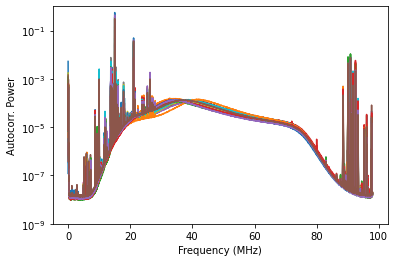

In [32]:
%matplotlib inline
for ant_ind in range(Nants):
    plt.plot(frequencies, spec[ant_ind,:])
plt.ylim([1.e-9,1.e0])
plt.yscale('log')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Autocorr. Power')
plt.show()